<a href="https://colab.research.google.com/github/meghamkpatel/Skunks_Skool/blob/main/INFO_6105/AutoML/Red_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Science Engineering
##Assignment 2 - 80 Cereals
*AutoML*
_______________________________________


##Abstract
Breakfast is the most important meal of the day! Cereals combined with milk are traditionally eaten food to kick start a healthy day. But how healthy is your cereal?  

Some companies promote their products for the health benefits that come from eating oat-based and high-fiber cereals. In the United States, cereals are often fortified with vitamins but can still lack many of the vitamins needed for a healthy breakfast. A significant proportion of cereals have a high sugar content ("sugar cereals" or "sugary cereals" in common parlance).

###Goal
In this notebook, we examine popular cereal brands and their nutritional facts including, calories, protein, fat, sodium, fiber, carbohydrates, sugars, potassium, and vitamins as well as external characteristics such as manufacturer, type, shelf level, weight, and number of cups per serving to predict ratings.

###Attributes
* name: Name of cereal
* mfr: Manufacturer of cereal
  * A = American Home Food Products;
  * G = General Mills
  * K = Kelloggs
  * N = Nabisco
  * P = Post
  * Q = Quaker Oats
  * R = Ralston Purina
* type:
  * cold
  * hot
* calories: calories per serving
* protein: grams of protein
* fat: grams of fat
* sodium: milligrams of sodium
* fiber: grams of dietary fiber
* carbo: grams of complex carbohydrates
* sugars: grams of sugars
* potass: milligrams of potassium
* vitamins: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended
* shelf: display shelf (1, 2, or 3, counting from the floor)
* weight: weight in ounces of one serving
* cups: number of cups in one serving
* rating: a rating of the cereals (Possibly from Consumer Reports?)




###Initializing H2O...

In [1]:
#installing h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.2 MB 46 kB/s 
  Created wheel for h2o: filename=h2o-3.38.0.1-py2.py3-none-any.whl size=177276478 sha256=549ff85fca79b57c8e016def0e442b702924a1bcb3b3614b9fb5f22493473f27
  Stored in directory: /root/.cache/pip/wheels/a1/a1/d9/bb37df368c4635a707e7362d1088450b606041f05aeba5f173
Successfully built h2o


In [2]:
#importing all necessary libraries
%matplotlib inline  
import random, os, sys
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np

In [3]:
min_mem_size=6 
run_time=333

In [4]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

6


In [5]:
#installing dependencies
!pip install eli5
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 7.2 MB/s 
     |████████████████████████████████| 133 kB 12.1 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=bcb018678c17313880a7f61a1f9ad19c63bde5874864347eeca5a73b63705926
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [6]:
#making a directory for kaggle api
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [7]:
#downloading and reading the 80 cereal dataset
! kaggle datasets list -s '80 cereals' # searching through kaggle with keyword '80 cereals'
! kaggle datasets download -d crawford/80-cereals 
!unzip 80-cereals.zip

ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
crawford/80-cereals                                            80 Cereals                                          2KB  2017-10-24 18:25:20          38902        526  0.85294116       
masoodhussain/80-cereals-nutrition-data-on-80-cereal-products  80 Cereals: Nutrition data on 80 cereal products    4KB  2017-11-14 10:09:45            169          3  0.1764706        
kagema/80-cereals                                              80 Cereals                                          2KB  2017-10-24 12:21:27             47          0  0.23529412       
shubhamsingh2001/crop-yield                                    crop yield  

In [8]:
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu118.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu118.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprnl555oc
  JVM stdout: /tmp/tmprnl555oc/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmprnl555oc/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 6 days
H2O_cluster_name:,H2O_from_python_unknownUser_n2149g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [9]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

In [42]:
#Viewing data in the file 
df = pd.read_csv("cereal.csv")
data = h2o.import_file("cereal.csv")
data.shape
data.describe()
data.head()


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:77
Cols:16

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
type,string,enum,enum,int,int,int,int,real,real,int,int,int,int,real,real,real
mins,NaN,,,50.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,1.0,0.5,0.25,18.042851
mean,NaN,,,106.8831168831169,2.545454545454545,1.0129870129870129,159.67532467532473,2.1519480519480525,14.597402597402601,6.922077922077923,96.07792207792208,28.246753246753244,2.2077922077922074,1.0296103896103896,0.8210389610389608,42.665704987012965
maxs,NaN,,,160.0,6.0,5.0,320.0,14.0,23.0,15.0,330.0,100.0,3.0,1.5,1.5,93.704912
sigma,NaN,,,19.484119056820845,1.094789748445534,1.0064725594803927,83.83229524009316,2.3833639643872226,4.278956280325907,4.4448853924193585,71.2868125092621,22.342522500566307,0.832524100135788,0.15047679973689213,0.23271613844691388,14.047288743735217
zeros,0,,,0,0,27,9,19,0,7,0,8,0,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,100% Bran,N,C,70.0,4.0,1.0,130.0,10.0,5.0,6.0,280.0,25.0,3.0,1.0,0.33,68.402973
1,100% Natural Bran,Q,C,120.0,3.0,5.0,15.0,2.0,8.0,8.0,135.0,0.0,3.0,1.0,1.0,33.983679
2,All-Bran,K,C,70.0,4.0,1.0,260.0,9.0,7.0,5.0,320.0,25.0,3.0,1.0,0.33,59.425505


name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
100% Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33,68.403
100% Natural Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1,33.9837
All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33,59.4255
All-Bran with Extra Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.5,93.7049
Almond Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75,34.3848
Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1,0.75,29.5095
Apple Jacks,K,C,110,2,0,125,1,11,14,30,25,2,1,1,33.1741
Basic 4,G,C,130,3,2,210,2,18,8,100,25,3,1.33,0.75,37.0386
Bran Chex,R,C,90,2,1,200,4,15,6,125,25,1,1,0.67,49.1203
Bran Flakes,P,C,90,3,0,210,5,13,5,190,25,3,1,0.67,53.3138


In [11]:
train, test = data.split_frame(seed = 1234, destination_frames = ["train.hex", "test.hex"])


In [12]:
# assign target and inputs for logistic regression
y = 'rating'
X = [name for name in train.columns if name != y]
print(y)
print(X)

rating
['name', 'mfr', 'type', 'calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars', 'potass', 'vitamins', 'shelf', 'weight', 'cups']


###Regression

In [13]:
aml = H2OAutoML(max_runtime_secs=run_time,exclude_algos = ['DeepLearning'])

In [14]:
aml.train(x=X,y=y,training_frame=train)  # Change training_frame=train

AutoML progress: |
00:35:18.182: _train param, Dropping bad and constant columns: [name]


00:35:20.415: _train param, Dropping bad and constant columns: [name]

█
00:35:21.275: _train param, Dropping bad and constant columns: [name]
00:35:21.275: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 54.0.
00:35:21.294: _train param, Dropping unused columns: [name]
00:35:21.571: _train param, Dropping bad and constant columns: [name]

█
00:35:22.534: _train param, Dropping bad and constant columns: [name]

██
00:35:24.882: _train param, Dropping bad and constant columns: [name]

██
00:35:26.999: _train param, Dropping bad and constant columns: [name]

█
00:35:28.784: _train param, Dropping bad and constant columns: [name]

██
00:35:30.456: _train param, Dropping unused columns: [name]
00:35:30.765: _train param, Dropping unused columns: [name]
00:35:31.16: _train param, Dropping bad and constant columns: [nam

,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,1.2375369,0.3400462,1.0517771,1.8120505,0.9457378,1.2527244,1.1253948
mean_residual_deviance,2.8510253,2.703217,1.6908817,7.643021,1.0693514,2.0571444,1.7947283
mse,2.8510253,2.703217,1.6908817,7.643021,1.0693514,2.0571444,1.7947283
null_deviance,1613.9028,494.81912,1497.3274,1299.2976,1679.0593,2427.623,1166.2069
r2,0.9765294,0.0270276,0.9909400,0.9284260,0.9915855,0.9859057,0.9857900
residual_deviance,31.077017,30.320774,13.527054,84.073235,12.832217,28.800022,16.152555
rmse,1.5745969,0.6816065,1.3003391,2.7646015,1.0340945,1.4342749,1.3396747
rmsle,0.0392922,0.0112234,0.0333801,0.0529853,0.0250047,0.0478419,0.0372492


In [15]:
print(aml.leaderboard)

model_id                                                   rmse       mse      mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20221026_03517  1.69648   2.87806  1.24764  0.0412444                   2.87806
StackedEnsemble_BestOfFamily_6_AutoML_1_20221026_03517  1.77066   3.13522  1.37127  0.0447778                   3.13522
GLM_1_AutoML_1_20221026_03517                           1.78334   3.1803   1.42511  0.0474489                   3.1803
StackedEnsemble_AllModels_5_AutoML_1_20221026_03517     2.1675    4.69806  1.71828  0.0555217                   4.69806
StackedEnsemble_BestOfFamily_4_AutoML_1_20221026_03517  3.14269   9.87651  2.34599  0.0835047                   9.87651
StackedEnsemble_BestOfFamily_3_AutoML_1_20221026_03517  3.16814  10.0371   2.3964   0.0844975                  10.0371
StackedEnsemble_AllModels_1_AutoML_1_20221026_03517     3.28118  10.7662   2.49369  0.0831681                  10.7662
StackedEnsemble_AllModels_3_AutoML_1_202210

###Answer Questions using Leading Model
**1. Is the relationship significant?**
 

In [16]:
best_model = h2o.get_model(aml.leaderboard[2,'model_id'])
best_model.algo

'glm'

In [17]:
best_model.r2(train=True)

0.9904745140952762

In [18]:
print(best_model.r2(valid=True))

None


In [19]:
print(best_model.r2(xval = True))

0.9779243356240078


In [20]:
perf = aml.leader.model_performance(test)
perf

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 2.1878940873778085
RMSE: 1.4791531656247803
MAE: 1.059145695510635
RMSLE: 0.025866180042948248
Mean Residual Deviance: 2.1878940873778085
R^2: 0.9921656592399126
Null degrees of freedom: 22
Residual degrees of freedom: 21
Null deviance: 7555.614683720491
Residual deviance: 50.321564009689595
AIC: 89.2787805042492

In [28]:
best_model.confusion_matrix()

AttributeError: ignored

According to R^2, we see a high correlation in our training model. In a General Linear Model, having a a R^2 value close to one suggests there is a significant relationship.

**2. Are any model assumptions violated?**

General Linear Modeling makes four assumptions: linearity, homoskedasticity (constant variance), normality, and independence. 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

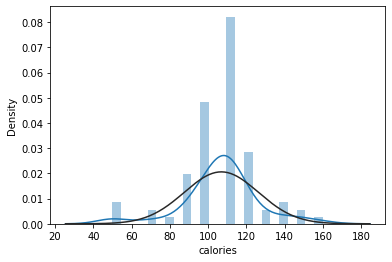

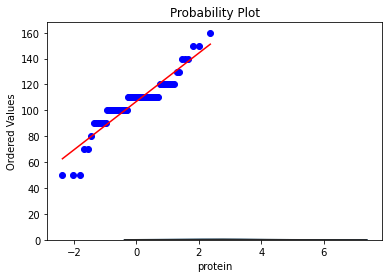

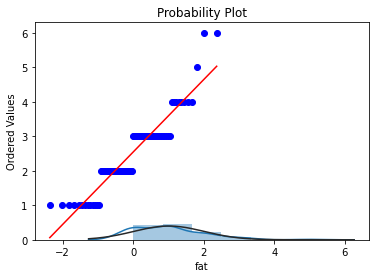

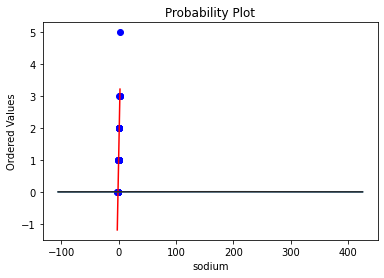

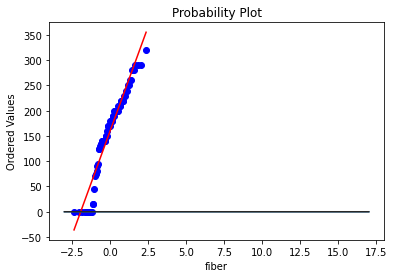

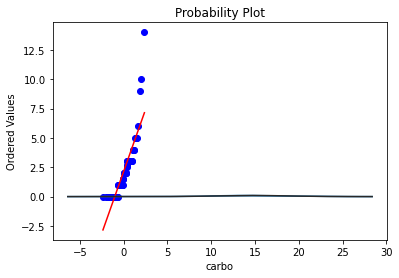

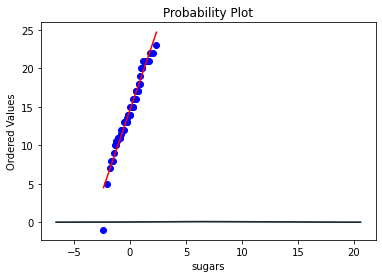

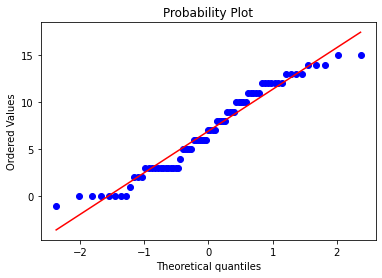

In [45]:
import seaborn as sns
#checking the distribution of independent variables
from statsmodels.graphics.gofplots import qqplot
data_temp=df[['calories', 'protein', 'fat', 'sodium', 'fiber', 'carbo', 'sugars']]
data_temp=data_temp.astype({'calories':'float', 'protein':'float', 'fat':'float', 'sodium':'float', 'fiber':'float', 'carbo':'float', 'sugars':'float'})
for c in data_temp.columns[:]:
  #transformed histogram and normal probability plot
  sns.distplot(data_temp[c], fit=norm);
  fig = plt.figure()
  res = stats.probplot(data_temp[c], plot=plt)

<Figure size 1152x720 with 0 Axes>

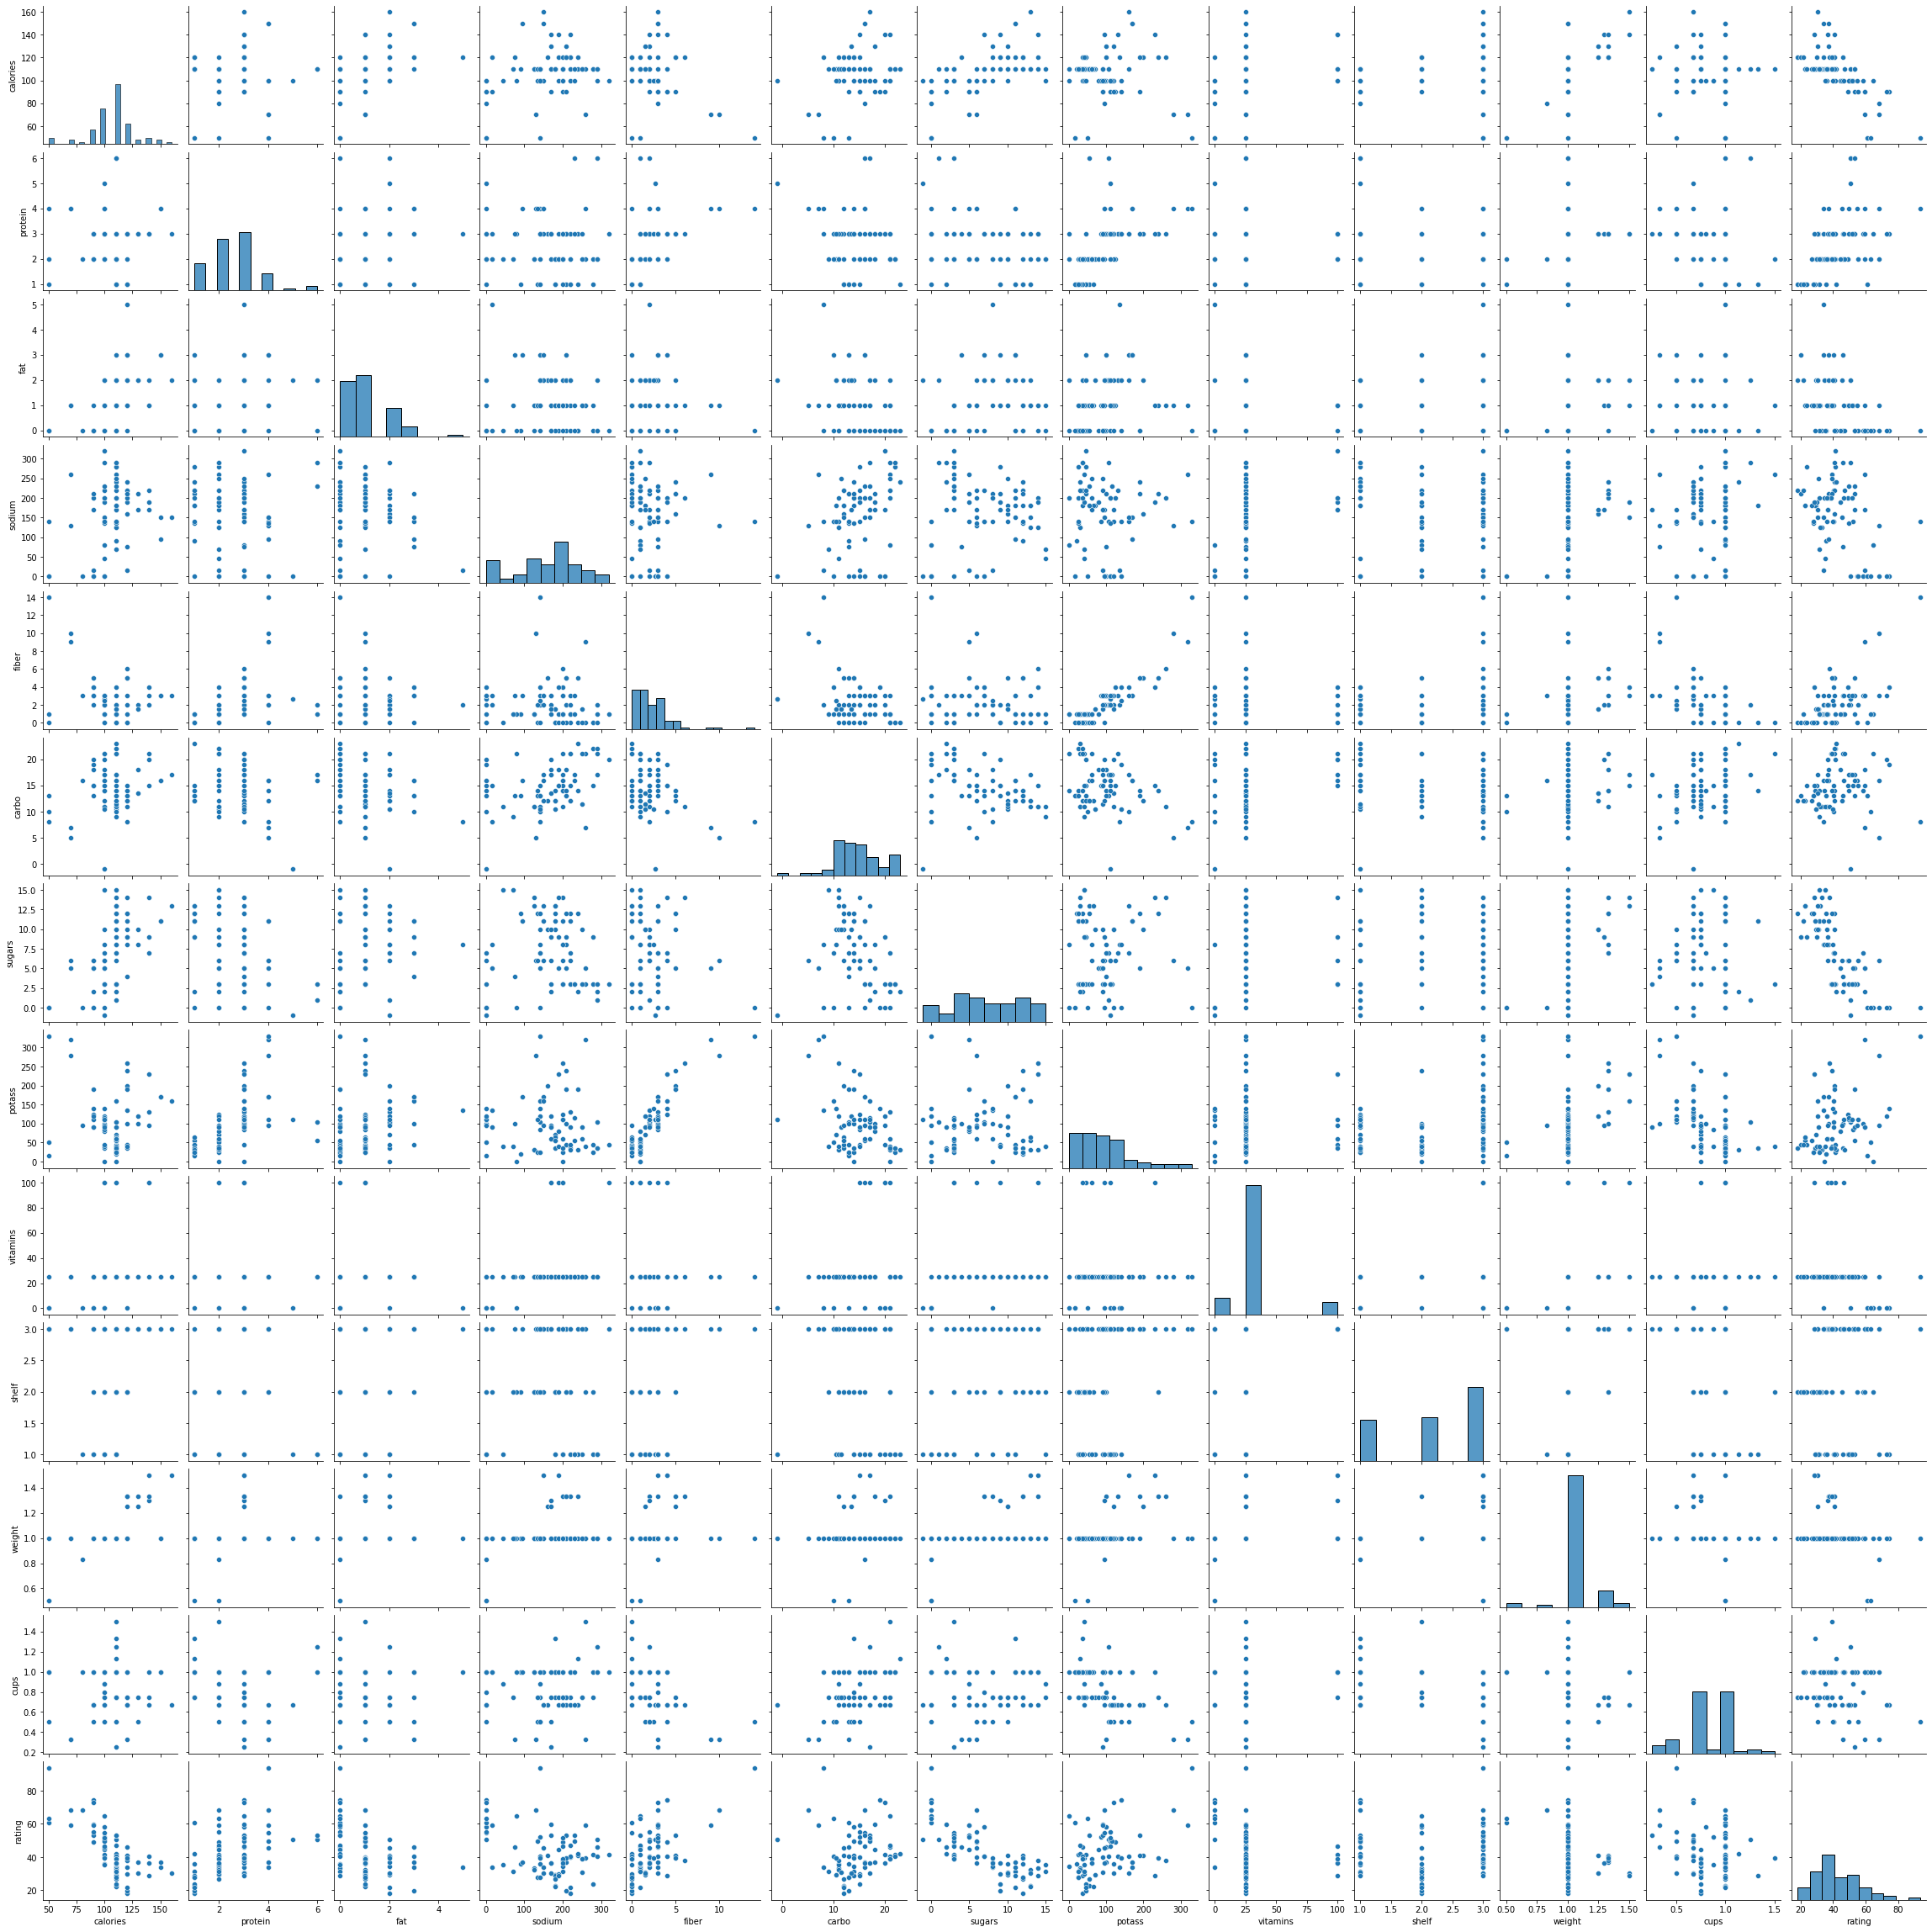

In [47]:
plt.figure(figsize=(16,10))
sns.pairplot(data=df)
plt.show()

**3. Is there any multicollinearity in the model?**

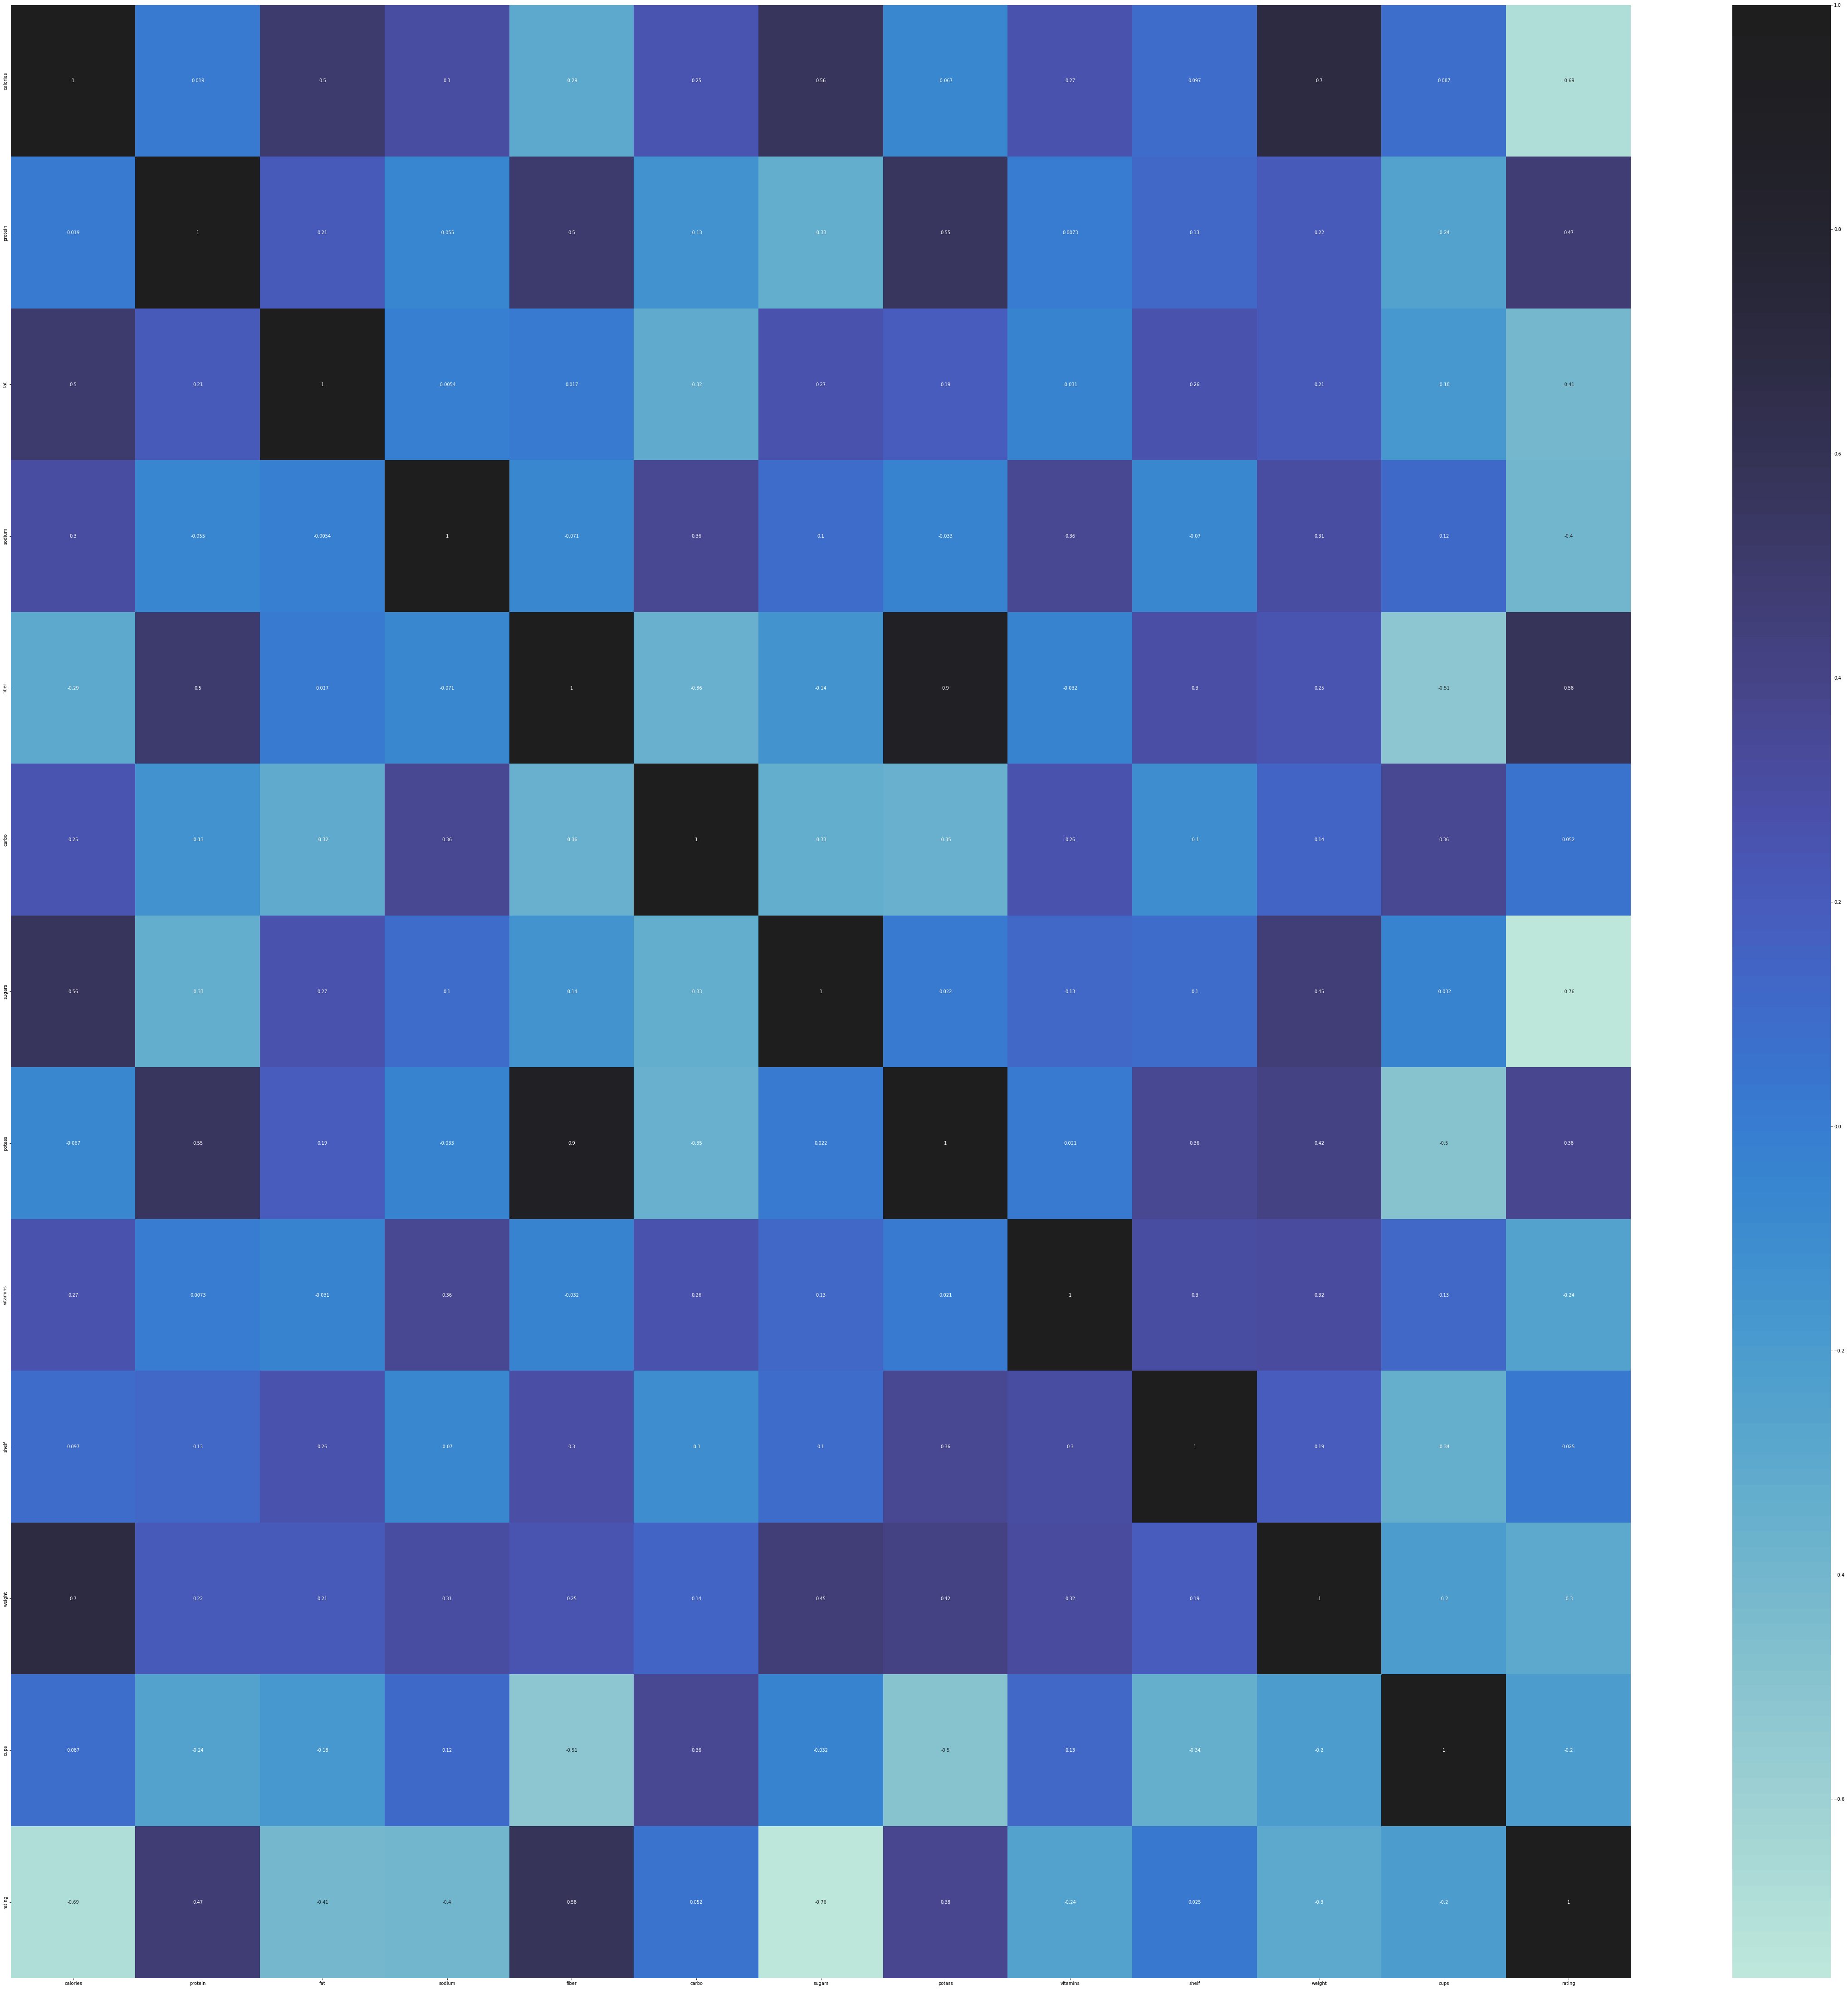

In [48]:
plt.figure(figsize = (80, 80))
corr=df.corr()
sns.heatmap(corr, annot = True, center=1)
plt.show()

**4. In the multivariate models are predictor variables independent of all the other predictor variables?**

looks calories and sugar have a relationship

**5. In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

In [49]:
best_model.varimp()

[('sugars', 4.074331283569336, 1.0, 0.1383595940359663),
 ('fiber', 3.8499345779418945, 0.9449242857269923, 0.13073934056791206),
 ('sodium', 3.4797980785369873, 0.8540783349086172, 0.11816993169287031),
 ('calories', 3.1909005641937256, 0.7831716034142229, 0.10835930510888865),
 ('carbo', 3.147005796432495, 0.7723981133108908, 0.10686868939184113),
 ('protein', 3.1195433139801025, 0.7656577477046032, 0.10593609514290118),
 ('fat', 2.110769271850586, 0.5180652050467132, 0.07167929145442285),
 ('mfr.N', 1.52144193649292, 0.37342126366318795, 0.05166641444483621),
 ('mfr.G', 0.9283328056335449, 0.2278491219840805, 0.03152511201916874),
 ('vitamins', 0.9251322746276855, 0.2270635866942119, 0.03141642567536159),
 ('mfr.Q', 0.8302851915359497, 0.20378440871616474, 0.028195528060827982),
 ('potass', 0.6330066323280334, 0.15536454654062523, 0.021496175586942896),
 ('type.H', 0.4088495671749115, 0.10034764939799815, 0.0138840600331705),
 ('type.C', 0.4078103005886078, 0.10009257279426326, 0.01

**6. Does the model make sense?**

**7. Does regularization help?**

**8. Which independent variables are significant?**

In [ ]:
#prove using z score values

**9. Which hyperparameters are important?**

In [ ]:
#gini vs shannon

#Conclusion